# Retrain or not Retrain? Online Machine Learning with Gradient Boosting

**Comparing Refit Strategies for Continuos Learning in Scikit-Learn**

Training a machine learning model requires energy, time, and patience. Smart **data scientists organize experiments and track trials on the historical data** to deploy the best solution. Problems may arise when we pass newly available samples to our pre-build machine learning pipeline. In the case of predictive algorithms, **the registered performances may diverge from the expected ones.**

The causes behind discrepancies are variegated. Excluding technical mistakes, **the most common and feared responsible is data drift.** From the standard distribution shift to the sneaky multivariate and conceptual drift, we must prepare to handle all these situations.

In this post, **we don’t focus on how to detect data drift. We try to outline how to react in the presence of data drift.** Numerous interesting tools and fancy techniques have been introduced recently to facilitate data drift detection. That’s cool but what can we do after? *“Refit is all you need”* is the most known slogan used to handle the situation. In other words, when new labeled data became available, we should make our model continuously learn new insights from them.

With online machine learning, we refer to a multi steps training process to allow our algorithms to dynamically suit new patterns. If it’s properly made, it may provide great benefits (both in terms of speed and performance) over retraining from scratch. That’s exactly what we want to test in this post.

## Experiment Setup

We imagine operating in a streaming context where, at some regular time intervals, we can access new labeled data, calculate the metrics of interest, and retrain our predictive model.

We simulate a conceptual drift scenario. We have some features that maintain stationary and unchanged distributions over time. Our target is a linear combination of the features. The contributions of every single feature to the target are dynamic and not constant over time.

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor

In [3]:
### UTILITY FUNCTIONS ###

def smape(true, pred):
    true = np.asarray(true)
    pred = np.asarray(pred)
    return 100 * np.mean(2 * np.abs(true - pred) / (np.abs(true) + np.abs(pred)))


def sim_data(n_samples, n_features, return_coefs=True, random_state=0):
    
    np.random.seed(random_state)
    coefs = np.sin(np.random.normal(0,0.1, (n_samples,n_features)))
    coefs = np.cumsum(coefs, axis=0)

    X = np.random.normal(0,1, (n_samples,n_features))
    y = np.sum(X*coefs, axis=1)
    
    if return_coefs:
        return X, y, coefs
    else:
        return X, y

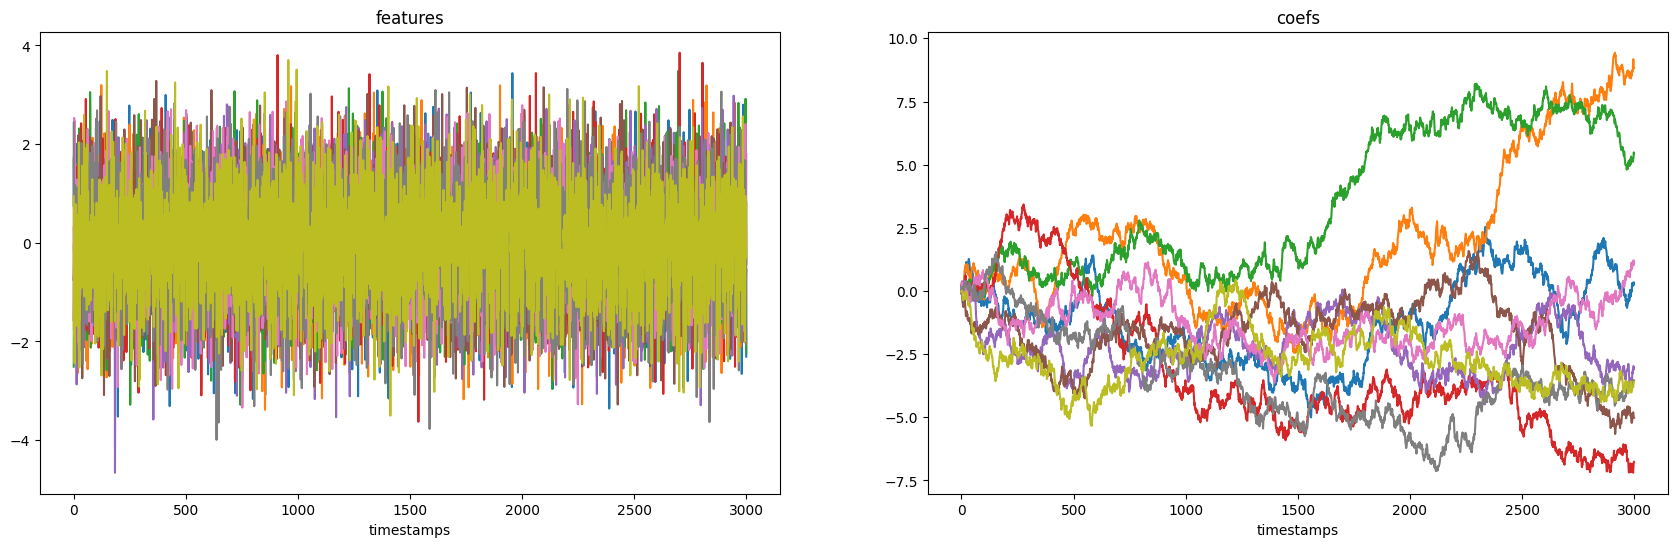

In [4]:
### SIMULATE DATA ###

X, y, coefs = sim_data(n_samples=3000, n_features=9, return_coefs=True, random_state=0)

plt.figure(figsize=(21,6))
plt.subplot(121)
plt.plot(X)
plt.xlabel('timestamps'); plt.title('features')
plt.subplot(122)
plt.plot(coefs)
plt.xlabel('timestamps'); plt.title('coefs')
plt.show()

In this situation, using the same predictive model trained a time ago may be useless. Let’s investigate the option at our disposal.

## Refit is all you need

To learn the relationships between target and features **we need to frequently update our model. In this sense, we have different strategies at our disposal.**

We may adopt stateful learning where we initialize, at some predefined intervals, training from scratch with the data at our disposal. All we have to do is merge the new samples with the historical ones. We don’t need to store the previously fitted model since we recreate it.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*EGcg8-7PXczK3PVGTJvTYA.png)

A variation of *stateful learning it’s weighted stateful learning*. It consists in giving the latest observations a higher weight. This may be useful to weigh more the recent data and make the new model focus on the latest patterns. Carrying out a weighted training is straightforward. Lots of the latest machine learning algorithm implementations provide the build-in possibility to give each sample a different weight.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ewac8XB6-eeHNcX3anuSdQ.png)

On the other hand, we may consider *continuous learning, aka online machine learning*. In continuous learning, we use the previous model knowledge to initialize a new training step. We take the new set of available samples and make the previously fitted model learn new patterns from them. By updating (instead of reinitializing) the model knowledge, we hope to get better performances reducing the costs of training from scratch.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*WSQNCDvfv2cX9ewx-C1aCQ.png)

## Online Machine Learning in Practice

Online machine learning is natively supported by all neural network-based algorithms. We can anytime continue the training process by updating the loss sample-wise while passing new data.

Practically speaking, in the scikit-learn ecosystem, all the algorithms that support the partial_fit method can carry out continual learning. 

Coming back to our experiment, we test the three mentioned training strategies (stateful learning, weighted stateful learning, and continuous learning) on our simulated data using a SGDRegressor. We don’t do this a single time but we do it multiple times by simulating different scenarios to better take care of the variability in the simulation process. We regularly evaluate our models for 20 periods and store the prediction errors (calculated as SMAPE) for all the simulated scenarios.

In [5]:
### SIMULATE MULTIPLE ONLINE FIT WITH SGDRegressor ###

scoresW_ = {}
scoresF_ = {}
scores_ = {}

test_size = 100
CV = TimeSeriesSplit(20, test_size=test_size)

for j in tqdm(range(100)):
    
    _scoresW_ = []
    _scoresF_ = []
    _scores_ = []
    X, y = sim_data(n_samples=3000, n_features=9, return_coefs=False, random_state=j)
    
    for i,(id_train,id_test) in enumerate(CV.split(X)):

        ### weighted stateful ###
        fit_params = {'random_state':33, 'eta0':0.001}
        w = np.linspace(1,10, len(id_train))
        model = SGDRegressor(**fit_params).fit(
            X[id_train], y[id_train], sample_weight=w[id_train]**3
        )
        _scoresW_.append(smape(y[id_test], model.predict(X[id_test])))

        ### continuos ###
        fit_params = {'random_state':33, 'eta0':0.1}
        if i>0:
            previous_model = previous_model.partial_fit( 
                X[id_train[-test_size:]], y[id_train[-test_size:]]
            )
        else:
            previous_model = SGDRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scoresF_.append(smape(y[id_test], previous_model.predict(X[id_test])))

        ### stateful ###
        fit_params = {'random_state':33}
        model = SGDRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scores_.append(smape(y[id_test], model.predict(X[id_test])))
        
    scoresW_[j] = _scoresW_
    scoresF_[j] = _scoresF_
    scores_[j] = _scores_
    
    
scoresW_ = pd.DataFrame(scoresW_).T
scoresF_ = pd.DataFrame(scoresF_).T
scores_ = pd.DataFrame(scores_).T

scoresW_.shape, scoresF_.shape, scores_.shape

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


((100, 20), (100, 20), (100, 20))

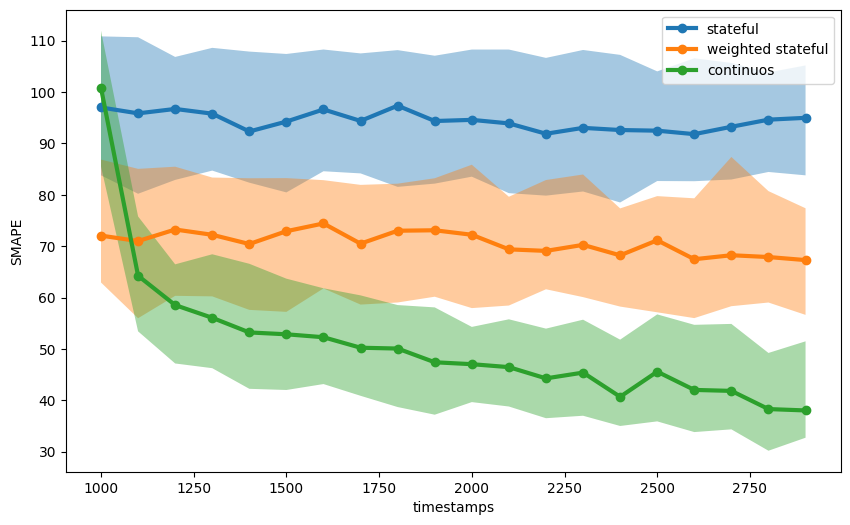

In [6]:
### ERROR COMPARISON ###

refit_range = np.arange(X.shape[0]-CV.n_splits*test_size, X.shape[0], test_size)

plt.figure(figsize=(10,6))
plt.plot(refit_range, scores_.median(), linewidth=3, marker='o', label='stateful')
plt.fill_between(refit_range, scores_.quantile(0.2), scores_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresW_.median(), linewidth=3, marker='o', label='weighted stateful')
plt.fill_between(refit_range, scoresW_.quantile(0.2), scoresW_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresF_.median(), linewidth=3, marker='o', label='continuos')
plt.fill_between(refit_range, scoresF_.quantile(0.2), scoresF_.quantile(0.8), alpha=0.4)
plt.ylabel('SMAPE'); plt.xlabel('timestamps'); plt.legend()

plt.show()

We can see that continuous learning can achieve the greatest performance compared to the other strategies. Giving more weight to the recent observations, weighted stateful learning can also do better than standard stateful learning.

These results sound promising. Is it possible to do online machine learning with other algorithms? We know the great power of tree-based gradient boosting. Lots of machine learning projects use them thanks to their adaptability in a variegated range of situations. It would be great to have the possibility to operate online machine learning also with them.

Hopefully, we can do it! It is easy as in the previous case. We report a snippet where we introduce how we can do it with LGBMRegressor.

In [7]:
### SIMULATE MULTIPLE ONLINE FIT WITH LGBMRegressor ###

scoresW_ = {}
scoresF_ = {}
scores_ = {}

test_size = 100
CV = TimeSeriesSplit(20, test_size=test_size)

for j in tqdm(range(100)):
    
    _scoresW_ = []
    _scoresF_ = []
    _scores_ = []
    X, y = sim_data(n_samples=3000, n_features=9, return_coefs=False, random_state=j)
    
    for i,(id_train,id_test) in enumerate(CV.split(X)):
        
        fit_params = {'n_estimators':50, 'linear_tree':True, 'random_state':33, 'n_jobs':-1}

        ### refit w/ weigths ###
        w = np.linspace(1,10, len(id_train))
        model = LGBMRegressor(**fit_params).fit(
            X[id_train], y[id_train], sample_weight=w**3
        )
        _scoresW_.append(smape(y[id_test], model.predict(X[id_test])))
        
        ### refit ###
        if i>0:
            previous_model = LGBMRegressor(**fit_params).fit(
                X[id_train[-test_size:]], y[id_train[-test_size:]], init_model=previous_model.booster_
            )
        else:
            previous_model = LGBMRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scoresF_.append(smape(y[id_test], previous_model.predict(X[id_test])))

        ### online fit ###
        model = LGBMRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scores_.append(smape(y[id_test], model.predict(X[id_test])))
        
    scoresW_[j] = _scoresW_
    scoresF_[j] = _scoresF_
    scores_[j] = _scores_
    
    
scoresW_ = pd.DataFrame(scoresW_).T
scoresF_ = pd.DataFrame(scoresF_).T
scores_ = pd.DataFrame(scores_).T

scoresW_.shape, scoresF_.shape, scores_.shape

100%|██████████| 100/100 [43:35<00:00, 26.16s/it]


((100, 20), (100, 20), (100, 20))

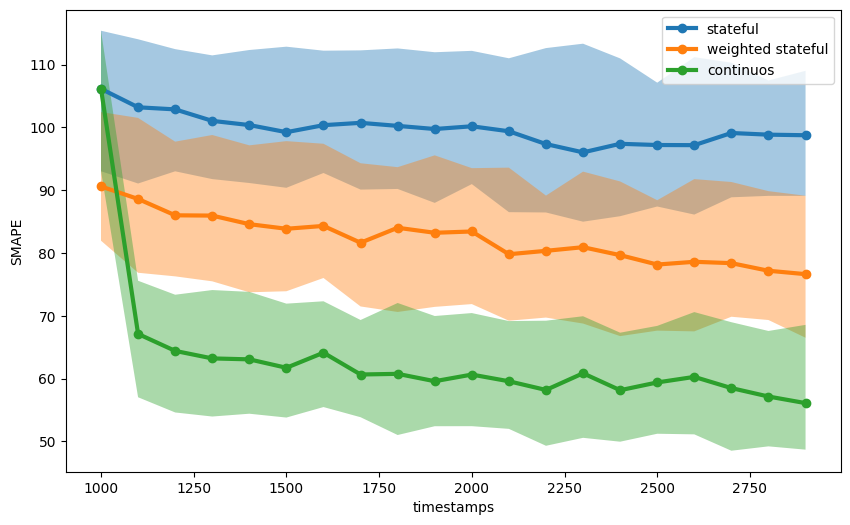

In [8]:
### ERROR COMPARISON ###

refit_range = np.arange(X.shape[0]-CV.n_splits*test_size, X.shape[0], test_size)

plt.figure(figsize=(10,6))
plt.plot(refit_range, scores_.median(), linewidth=3, marker='o', label='stateful')
plt.fill_between(refit_range, scores_.quantile(0.2), scores_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresW_.median(), linewidth=3, marker='o', label='weighted stateful')
plt.fill_between(refit_range, scoresW_.quantile(0.2), scoresW_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresF_.median(), linewidth=3, marker='o', label='continuos')
plt.fill_between(refit_range, scoresF_.quantile(0.2), scoresF_.quantile(0.8), alpha=0.4)
plt.ylabel('SMAPE'); plt.xlabel('timestamps'); plt.legend()

plt.show()

We achieve the same satisfactory results as before. If properly handled, online machine learning sounds to be effective and available with different algorithms.